# 2D Poisson Problem

In [12]:
# Import the FEMSystem Class from directory above
import sys
sys.path.append('..')
from FEMSystem import FEMSystem

# Remaining Imports
import jax.numpy as jnp
import skfem as fem
from jaxopt import LBFGS

## Step 1: Create FEMSystem Object with Mesh and Element

In [13]:
# Create the FEMSystem Object
mesh = fem.MeshTri.init_sqsymmetric().refined(5)
element = fem.ElementTriP1()
intorder = 3  

femsystem = FEMSystem(mesh,element,intorder,boundary_condition=0)

## Step 2: Define Optimization Objective

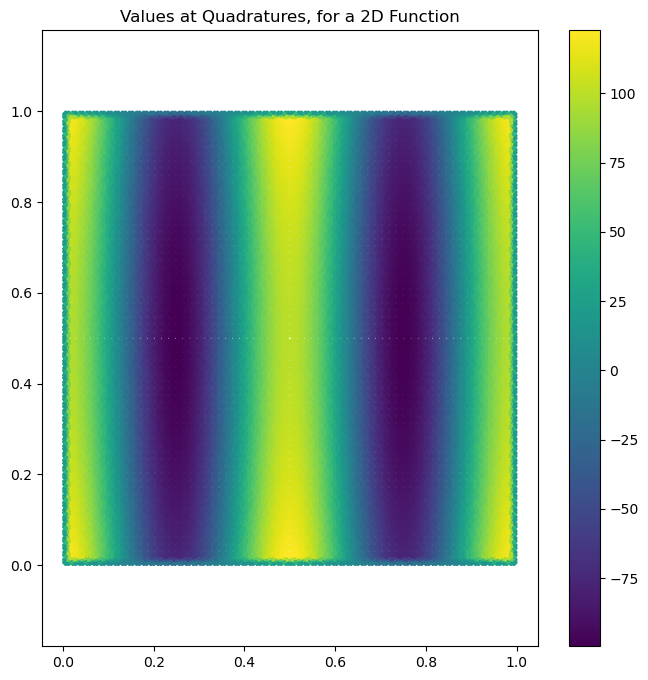

In [14]:
def v(x,y):
    return 100 * jnp.cos(4*jnp.pi*x) + 100 * (y-0.5)**2 

def lagrangian_density(u,grad_u,x):
    kinetic = 0.5 * jnp.sum(grad_u**2, axis=0) 
    
    x, y = x[0], x[1]
    f = v(x,y)
    potential = f * (u**2)
    
    return kinetic + potential

# Our objective function is to integrate the lagrangian density
def objective(u_interior):
    u_global = femsystem.apply_bc_and_norm(u_interior)
    return femsystem.integrate(lagrangian_density,u_global)

# Plot the 2D Potential, to Visualize
femsystem.plot_values_2d(v)

## Step 3: Run Optimization Loop

In [16]:
# Interior nodes are those NOT in boundary_dofs
u_init_interior = jnp.ones(len(femsystem.interior_dofs))
print("\nStarting Optimization...")
# Use JAX's BFGS optimizer
solver = LBFGS(fun=objective,tol=1e-10,verbose=True)
result = solver.run(u_init_interior)
result = result.params # The interior points


Starting Optimization...
INFO: jaxopt.LBFGS: Iter: 1 Gradient Norm (stopping criterion): 9.309236526489258 Objective Value:66.83650207519531  Stepsize:0.4992538094520569  Number Linesearch Iterations:2 
INFO: jaxopt.LBFGS: Iter: 2 Gradient Norm (stopping criterion): 6.117148399353027 Objective Value:48.173370361328125  Stepsize:0.7488807439804077  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 3 Gradient Norm (stopping criterion): 5.545551300048828 Objective Value:26.094676971435547  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 4 Gradient Norm (stopping criterion): 10.006612777709961 Objective Value:19.427955627441406  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 5 Gradient Norm (stopping criterion): 4.758595943450928 Objective Value:9.694738388061523  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 6 Gradient Norm (stopping criterion): 3.5966105461120605 Objective Value:2.0842068195343018  Stepsi

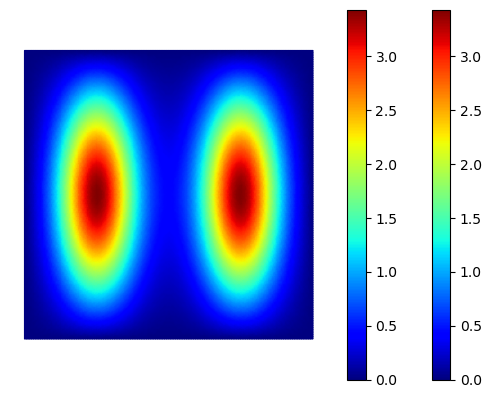

In [17]:
# Plot the Solution
femsystem.plot_at_interior_2d(result)

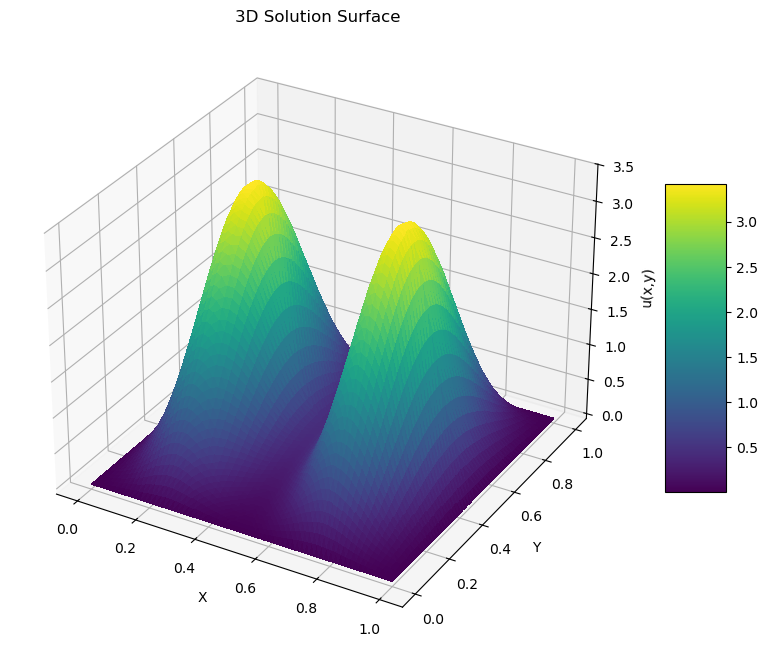

In [18]:
# Plot in 3D: 
femsystem.plot_at_interior_2d_in3d(result)